# Introduction

In order to cover the Classical Arabic (a.k.a. FosHa الفصحى) in our data set, Elmktaba Elshamela, and The Holy Quran Corpus are a great resource for such data distribution with high quality cleaned text extracted from islamic books. 

> Elmktaba Elshamela website contains 2911 books. 
> http://shamela.ws/

> The Holy Quran Corpus.
> https://www.kaggle.com/zusmani/the-holy-quran


---

***The Methodology:***
*   Scrape ***`Elmktaba Elshamela`*** website using `Beatiful Soup` 
library to extract books info and their download urls.
*   Download the books in `.epub` format.
*   Convert the `.epub` formatted files to plain text, and save them to `.txt` files.
*   Clean the text of both ***`Elmktaba Elshamela`***, and ***`The Holy Quran Corpus`*** by removing the non-arabic characters, and remove diacritization (tashkeel).
*   Creat the ***`Classical Arabic Corpus`*** by saving all books in a big single `.txt` file.



# Imports

In [0]:
!pip install -q -U pyarabic epub-conversion wget bs4 tqdm xml_cleaner ftfy arabic_reshaper python-bidi wordcloud

In [0]:
from pyarabic import araby
from epub_conversion import Converter
from epub_conversion.utils import open_book, convert_epub_to_lines, convert_lines_to_text
from itertools import chain
import wget
import bs4 
import requests 
import re
from tqdm.notebook import tqdm
import json
import os
import sys
import urllib
import string
import pandas as pd
import ftfy
import arabic_reshaper
from bidi.algorithm import get_display
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline
from collections import Counter

#Utils

In [0]:
class Epub2Text:
    def __init__(self, books_dir):
        Converter(books_dir)
    
    def epub2text(self, epub_path):
        book = open_book(epub_path)
        lines = convert_epub_to_lines(book)
        # clean text by remove non-arabic characters, \n, and remove diacritization (tashkeel).
        text = " ".join(araby.tokenize( ' '.join(' '.join([' '.join(convert_lines_to_text(l, '')) for l in lines]).replace('\n', '').split()) , conditions=araby.is_arabicrange, morphs=araby.strip_tashkeel))
        return text
    
    def write_text_file(self, output_path, text):
        with open(output_path, 'w') as f:
            f.write(text)

In [0]:
def mkdirs(base_path, cats):
    for cat in tqdm(cats):
        dir = os.path.join(base_path, cat) 
        os.makedirs(dir)

In [0]:
def download_books(url, book_name, category, authors):
    if 'Elmktaba_Elshamela_Books_Dump' not in os.listdir('/content/'):
        os.makedirs('/content/Elmktaba_Elshamela_Books_Dump/')
    f_name = f"{'_'.join(re.sub(pattern=f'[{string.punctuation}]', repl=' ', string=book_name).split())}-{'_'.join(re.sub(pattern=f'[{string.punctuation}]', repl=' ', string=authors).split())}"
    f_name = f_name[:99]
    f_path = f"/content/Elmktaba_Elshamela_Books_Dump/{category}/{f_name}.epub"
    !wget -q $url -O $f_path
    # fn = wget.download(url, out=f_path)
    # os.rename(f"{fn}", f"{fn}.epub")

In [0]:
def word_cloud_text_cleaning(text):
    text = ftfy.fix_text(text)
    text = arabic_reshaper.reshape(text)
    text = get_display(text)

    return text

[SC_AMEEN.ttf](https://drive.google.com/open?id=1QoNJbZr1KB9_-z0fEv8IJ6XSP1bUdjKu)

In [0]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1TfdnY452FJiAvq5qKIBrn4oDaIJiNo4t' -O '/content/SC_AMEEN.ttf'

--2020-03-01 18:55:46--  https://docs.google.com/uc?export=download&id=1TfdnY452FJiAvq5qKIBrn4oDaIJiNo4t
Resolving docs.google.com (docs.google.com)... 173.194.217.100, 173.194.217.102, 173.194.217.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.217.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/88fshel24ou8phan1cn7govgdq2k9o06/1583088900000/10517787285812593535/*/1TfdnY452FJiAvq5qKIBrn4oDaIJiNo4t?e=download [following]
--2020-03-01 18:55:46--  https://doc-0k-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/88fshel24ou8phan1cn7govgdq2k9o06/1583088900000/10517787285812593535/*/1TfdnY452FJiAvq5qKIBrn4oDaIJiNo4t?e=download
Resolving doc-0k-74-docs.googleusercontent.com (doc-0k-74-docs.googleusercontent.com)... 173.194.216.132, 2607:f8b0:400c:c12::84
Connecting to doc-0k-74-docs.googleusercontent.com (doc-0k

In [0]:
def word_cloud(text, width=1000, height=1000, max_words = 2000, counter=None):
    if counter:
        w_c = WordCloud(background_color="white", max_words=max_words, font_path= '/content/SC_AMEEN.ttf', 
                   contour_width=3, contour_color='steelblue', height=height, width=width).generate_from_frequencies(counter)
    else:
        w_c = WordCloud(background_color="white", max_words=max_words, font_path= '/content/SC_AMEEN.ttf', 
                    contour_width=3, contour_color='steelblue', height=height, width=width).generate(text)
    return w_c

In [0]:
def draw_word_cloud(text, counter=None):
    if counter:
        counter = Counter({word_cloud_text_cleaning(k): v for k, v in tqdm(counter.items())})
        wc = word_cloud(text=None, counter=counter)
    else:
        wc = word_cloud(word_cloud_text_cleaning(text))
    plt.figure(figsize=[15,10])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Elmktaba Elshamela

## Scrape

In [0]:
def access_link(url):
    res = requests.get(url=url)
    try:
        res.raise_for_status()
    except:
        pass
    return res


def is_page(url):
    return access_link(url).status_code == 200


def formated(text):
    return '_'.join([''.join([c for c in araby.tokenize(w, conditions=araby.is_arabicrange, morphs=araby.strip_tashkeel) if re.search(pattern=u"([\u0600-\u0652\ufefb\u0644\u0623\u0644\u0622])", string=c)]) for w in text.split()])


def extract_book_info(url):
    res = access_link(url)
    html = bs4.BeautifulSoup(res.text)
    
    cat = formated(html.select("#breadcrumbs a")[0].text.replace(" - مرقم آليا", ""))
    book_title = formated(html.select("#breadcrumbs")[0].text.split('•')[1].strip())[:99]
    author = formated(html.select("#content h3 span a")[0].text)
    book_url = [i.get('href') for i in html.select('#content div + div a + a') if i.get('href').endswith(".epub")][0]
    
    output = {
        "cat": cat,
        'book_title': book_title,
        'author': author,
        'book_url': book_url
    }
    return output


def get_cats_links():
    res = access_link('http://shamela.ws/index.php/categories')
    html = bs4.BeautifulSoup(res.text)
    cats_links = {i.text: 'http://shamela.ws' + i.get('href') for i in html.select('#content ul li a')}
    return cats_links


def get_books_data():
    books_data = dict()

    cats_links = get_cats_links()
    
    for c, l in tqdm(cats_links.items()):
        res = access_link(l)
        html = bs4.BeautifulSoup(res.text)
        selector = html.select('#content div a')
        if len(selector) > 0:
            last_page_index = int(selector[1].get('href')[-1])
        else:
            last_page_index = 1
        
        for i in range(last_page_index):
            res2 = access_link(f'{l}/page-{str(i+1)}')
            html2 = bs4.BeautifulSoup(res2.text)
            book_selector = html2.select('.regular-book > a')
            books_urls = ['http://shamela.ws' + j.get('href') for j in book_selector if not 'get_pdf' in j.get('href')]
            books_titles = [formated(j.get('title')) for j in book_selector if j.get('title')]
            authors = [formated(j.get('title')) for j in html2.select('.ignore')]
            
            books_data[c] = {"books_urls":books_urls,
                                "books_titles": books_titles,
                                "authors": authors}
    return books_data


def scrape_shamela_books():
    scraped_books = dict()
    books_data = get_books_data()
    for v in tqdm(books_data.values()):
        for url in v['books_urls']:
            try:
                scraped_books[url] = extract_book_info(url)
            except:
                continue
    return scraped_books


def write_scraped_results(results, output_path):
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(results, f)
    print("Done :) ")

In [0]:
scraped_books = scrape_shamela_books()

In [0]:
# Save scraped books information.
write_scraped_results(scraped_books, 'shamela_books.json')

Done :) 


## Download Books

In [0]:
# Load books information.
with open('shamela_books.json', 'r', encoding='utf-8') as f:
    scraped_books = json.load(f)

In [0]:
# catigories
cats = {v['cat'] for v in scraped_books.values()}

In [0]:
BOOKS_DIR = '/content/Elmktaba_Elshamela_Books_Dump/'

In [0]:
mkdirs(base_path=BOOKS_DIR, cats=cats)

In [0]:
for k, v in tqdm(scraped_books.items()):
    url = v['book_url']
    book_title = v['book_title']
    author = v['author']
    cat = v['cat']

    try:
        download_books(url=url, book_name=book_title, category=cat, authors=author)
    except Exception as e:
        if "Error: HTTP Error 500: Internal Server Error" in e or "HTTP Error 404: Not Found" in e:
            continue
        print(f"Error: {e}")
        print("book_title: ", book_title, "url: ", url, '\n')
        raise

## Convert Epub files to Text files

In [0]:
bp = '/content/Books_txt/'

In [0]:
mkdirs(base_path=bp, cats=cats)

In [0]:
e2t = Epub2Text(books_dir=os.path.abspath(BOOKS_DIR))
success = 0
fails = 0
failed_files = []

for k, v in tqdm(scraped_books.items()):
    url = v['book_url']
    book_title = v['book_title']
    author = v['author']
    cat = v['cat']

    f_name = f"{'_'.join(re.sub(pattern=f'[{string.punctuation}]', repl=' ', string=book_title).split())}-{'_'.join(re.sub(pattern=f'[{string.punctuation}]', repl=' ', string=author).split())}"
    f_name = f_name[:99]
    f_path = f"{bp}{cat}/{f_name}.epub"

    try:
        text = e2t.epub2text(f_path)
    except:
        fails += 1
        failed_files.append(f_path)
        continue
    e2t.write_text_file(os.path.abspath(f'{BOOKS_DIR}/{cat}/{f_name}.txt'), text)
    success += 1
print(f"Done with {fails} faileur conversions out of {success} total. With success percentage of {fails * 100 / success}")

# Holy Quran ۞ ۩

In [0]:
# https://drive.google.com/open?id=15nciHBuI9CPaOY-PyWFzsDcxdftJfZ8Q
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=15nciHBuI9CPaOY-PyWFzsDcxdftJfZ8Q' -O '/content/Arabic-Original.csv'

--2020-03-01 18:56:07--  https://docs.google.com/uc?export=download&id=15nciHBuI9CPaOY-PyWFzsDcxdftJfZ8Q
Resolving docs.google.com (docs.google.com)... 173.194.216.113, 173.194.216.100, 173.194.216.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.216.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2fbtrjv749upsoparaudjucjpjmjkou3/1583088900000/10517787285812593535/*/15nciHBuI9CPaOY-PyWFzsDcxdftJfZ8Q?e=download [following]
--2020-03-01 18:56:08--  https://doc-0g-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2fbtrjv749upsoparaudjucjpjmjkou3/1583088900000/10517787285812593535/*/15nciHBuI9CPaOY-PyWFzsDcxdftJfZ8Q?e=download
Resolving doc-0g-74-docs.googleusercontent.com (doc-0g-74-docs.googleusercontent.com)... 173.194.216.132, 2607:f8b0:400c:c12::84
Connecting to doc-0g-74-docs.googleusercontent.com (doc-0g

In [0]:
def clean(text):
    return ' '.join([''.join([c for c in araby.tokenize(w, conditions=araby.is_arabicrange, morphs=araby.strip_tashkeel) if re.search(pattern=u"([\u0600-\u0652\ufefb\u0644\u0623\u0644\u0622])", string=c)]) for w in text.split()])

In [0]:
quran = pd.read_csv("/content/Arabic-Original.csv", names=['text'], header=None)

In [0]:
quran['normalized_text'] = quran['text'].apply(clean)
quran_text = ' '.join(quran['normalized_text'].values)

In [0]:
quran

,text,normalized_text
0,1|1|بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ,بسم الله الرحمن الرحيم
1,1|2|الْحَمْدُ لِلَّهِ رَبِّ الْعَالَمِينَ,الحمد لله رب العالمين
2,1|3|الرَّحْمَٰنِ الرَّحِيمِ,الرحمن الرحيم
3,1|4|مَالِكِ يَوْمِ الدِّينِ,مالك يوم الدين
4,1|5|إِيَّاكَ نَعْبُدُ وَإِيَّاكَ نَسْتَعِينُ,إياك نعبد وإياك نستعين
...,...,...
6231,114|2|مَلِكِ النَّاسِ,ملك الناس
6232,114|3|إِلَٰهِ النَّاسِ,إله الناس
6233,114|4|مِنْ شَرِّ الْوَسْوَاسِ الْخَنَّاسِ,من شر الوسواس الخناس
6234,114|5|الَّذِي يُوَسْوِسُ فِي صُدُورِ النَّاسِ,الذي يوسوس في صدور الناس


# Construct the Classical Arabic Books Corpus in single `.txt` file

In [0]:
bp = '/content/Books_txt/'
txt = quran_text + '\n\n'

for folder in tqdm(os.listdir(bp)):
    for f_name in os.listdir(f'{bp}{folder}'):
        f_path = f'{bp}{folder}/{f_name}'

        with open(f_path, 'r') as f:
            txt += f.read() + '\n\n'

with open('/content/classical_arabic_corpus.txt', 'w') as f:
    f.write(txt)

!du -sh /content/classical_arabic_corpus.txt

5.1G	/content/classical_arabic_corpus.txt


# Simple Analysis

[Classical Arabic Corpus](https://drive.google.com/open?id=1-0LuVbC1qBytrGZDskX2ziDG_IHh2Ox_)

In [0]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-0LuVbC1qBytrGZDskX2ziDG_IHh2Ox_' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-0LuVbC1qBytrGZDskX2ziDG_IHh2Ox_" -O '/content/classical_arabic_corpus.txt' && rm -rf /tmp/cookies.txt

--2020-03-01 06:25:01--  https://docs.google.com/uc?export=download&confirm=hQ_t&id=1-0LuVbC1qBytrGZDskX2ziDG_IHh2Ox_
Resolving docs.google.com (docs.google.com)... 172.217.203.139, 172.217.203.100, 172.217.203.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.203.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m0meajogdpau4c2ekfqckci4oa9gfqtq/1583043900000/10517787285812593535/*/1-0LuVbC1qBytrGZDskX2ziDG_IHh2Ox_?e=download [following]
--2020-03-01 06:25:01--  https://doc-10-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m0meajogdpau4c2ekfqckci4oa9gfqtq/1583043900000/10517787285812593535/*/1-0LuVbC1qBytrGZDskX2ziDG_IHh2Ox_?e=download
Resolving doc-10-74-docs.googleusercontent.com (doc-10-74-docs.googleusercontent.com)... 173.194.216.132, 2607:f8b0:400c:c12::84
Connecting to doc-10-74-docs.googleuserconten

In [0]:
!du -sh /content/classical_arabic_corpus.txt

5.1G	/content/classical_arabic_corpus.txt


In [0]:
import collections
freq_counter = collections.Counter()

In [0]:
n_tokens = 0

with open('/content/classical_arabic_corpus.txt', 'r') as f:
    # classical_arabic_corpus = f.read()
    for line in tqdm(f):
        s = line.split()
        n_tokens += len(s)
        freq_counter.update(s)


In [0]:
print(f"Total number of tokens is {int(n_tokens / 10**6)}M+ tokens; exactly {n_tokens} tokens.")

Total number of tokens is 601M+ tokens; exactly 601886477 tokens.


In [0]:
print(f"Number of unique tokens is {int(len(freq_counter) / 10**6)}M+ tokens; exactly  {len(freq_counter)}")

Number of unique tokens is 2M+ tokens; exactly  2226153


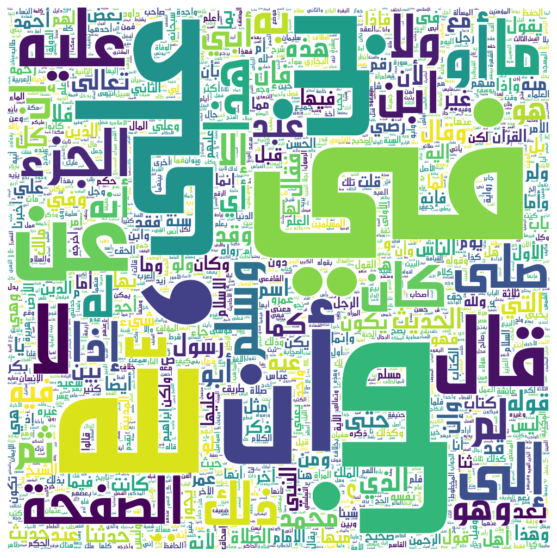

In [0]:
draw_word_cloud(text=None, counter=freq_counter)

In [0]:
freq_counter.most_common()

[('،', 33821650),
 ('في', 14177607),
 ('من', 12844112),
 ('الله', 9043068),
 ('على', 7022939),
 ('أن', 6733997),
 ('بن', 6252869),
 ('عن', 5592402),
 ('قال', 5208285),
 ('لا', 4925008),
 ('عليه', 4452358),
 ('ما', 4128888),
 ('أو', 3661068),
 ('إلى', 3585016),
 ('الجزء', 3006734),
 ('الصفحة', 2964316),
 ('كان', 2721844),
 ('هذا', 2713912),
 ('ذلك', 2509161),
 ('صلى', 2503882),
 ('ولا', 2456036),
 ('وسلم', 2425111),
 ('؛', 2423445),
 ('ابن', 2302021),
 ('له', 2250358),
 ('لم', 2198213),
 ('إذا', 2116029),
 ('به', 1955152),
 ('ثم', 1796635),
 ('إن', 1774986),
 ('عبد', 1760120),
 ('إلا', 1748135),
 ('وهو', 1732310),
 ('أنه', 1636572),
 ('أبي', 1623497),
 ('فيه', 1621660),
 ('هو', 1569384),
 ('الذي', 1430188),
 ('أي', 1391543),
 ('أبو', 1364867),
 ('محمد', 1338115),
 ('كما', 1322068),
 ('هذه', 1310580),
 ('فإن', 1281144),
 ('الحديث', 1237812),
 ('وإن', 1237091),
 ('رسول', 1222449),
 ('وقال', 1204089),
 ('قوله', 1203994),
 ('؟', 1197767),
 ('تعالى', 1197129),
 ('وقد', 1160017),
 ('عنه', 114

---
---

